In [1]:
import json
import pandas as pd
from pathlib import Path

with open("../Sample_Data/labeled_trackings_from_api.json") as f:
    data = json.load(f)

print(f"Loaded {len(data)} trackings.")


Loaded 8 trackings.


In [2]:
rows = []
for t in data:
    for point in t["points"]:
        row = {
            "tracking_id": t["id"],
            "name": t["name"],
            "label": t.get("label"),
            "duration": t["duration"],
            "length": t["length"],
            "latitude": point["latitude"],
            "longitude": point["longitude"],
            "sequence": point["sequence"],
            "speed": point["speed"],
            "time": point["time"],
        }
        rows.append(row)

df = pd.DataFrame(rows)
df["time"] = pd.to_datetime(df["time"])
df.head()


tracking_id                              name  label      duration  \
0        99476  0975abe81a084daeaf8b1b03f9afd981  URBAN  154460000000   
1        99476  0975abe81a084daeaf8b1b03f9afd981  URBAN  154460000000   
2        99476  0975abe81a084daeaf8b1b03f9afd981  URBAN  154460000000   
3        99476  0975abe81a084daeaf8b1b03f9afd981  URBAN  154460000000   
4        99476  0975abe81a084daeaf8b1b03f9afd981  URBAN  154460000000   

      length   latitude  longitude  sequence  speed                      time  
0  21.069127  48.282006  14.304086         0    0.0 2025-02-28 06:13:44+01:00  
1  21.069127  48.280932  14.301821         1    0.0 2025-02-28 06:13:56+01:00  
2  21.069127  48.280776  14.301146         2    0.0 2025-02-28 06:14:01+01:00  
3  21.069127  48.280854  14.301254         3    0.0 2025-02-28 06:14:08+01:00  
4  21.069127  48.281212  14.302188         4    0.0 2025-02-28 06:14:18+01:00

In [ ]:
import folium

m = folium.Map(location=[48.2, 14.3], zoom_start=12)

for _, row in df.iterrows():
    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=2,
        color="blue" if row["label"] == "RURAL" else "green",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m


In [4]:
from geopy.distance import geodesic

def extract_features(tracking):
    points = tracking["points"]
    if len(points) < 2:
        return None
    
    coords = [(p["latitude"], p["longitude"]) for p in points]
    
    dists = [
        geodesic(coords[i], coords[i+1]).meters
        for i in range(len(coords) - 1)
    ]
    total_dist = sum(dists)

    lats = [p["latitude"] for p in points]
    lons = [p["longitude"] for p in points]
    lat_span = max(lats) - min(lats)
    lon_span = max(lons) - min(lons)

    return {
        "tracking_id": tracking["id"],
        "label": tracking.get("label"),
        "length": tracking["length"],
        "duration": tracking["duration"] / 1e9,  
        "num_points": len(points),
        "bbox_area": lat_span * lon_span,
        "point_density": len(points) / (lat_span * lon_span + 1e-6),
        "avg_segment_distance": total_dist / len(dists),
        "num_stops": sum(1 for p in points if p["speed"] == 0)
    }

features = [extract_features(t) for t in data]
features = [f for f in features if f]  
features_df = pd.DataFrame(features)
features_df.head()


tracking_id     label      length  duration  num_points  bbox_area  \
0        99476     URBAN   21.069127    154.46         782   0.000971   
1        99713  SUBURBAN   43.080974    274.96         734   0.001321   
2        99307  SUBURBAN  113.679932    250.73        1496   0.016359   
3       100913     RURAL  134.669804    385.71        1934   0.029868   
4        99944     RURAL  227.180098    863.48        3033   0.074858   

   point_density  avg_segment_distance  num_stops  
0  804692.673498             26.377508        782  
1  555181.643849             57.350688        734  
2   91440.502533             75.228013       1496  
3   64749.352379             69.108692       1934  
4   40515.906612             72.715480       3033

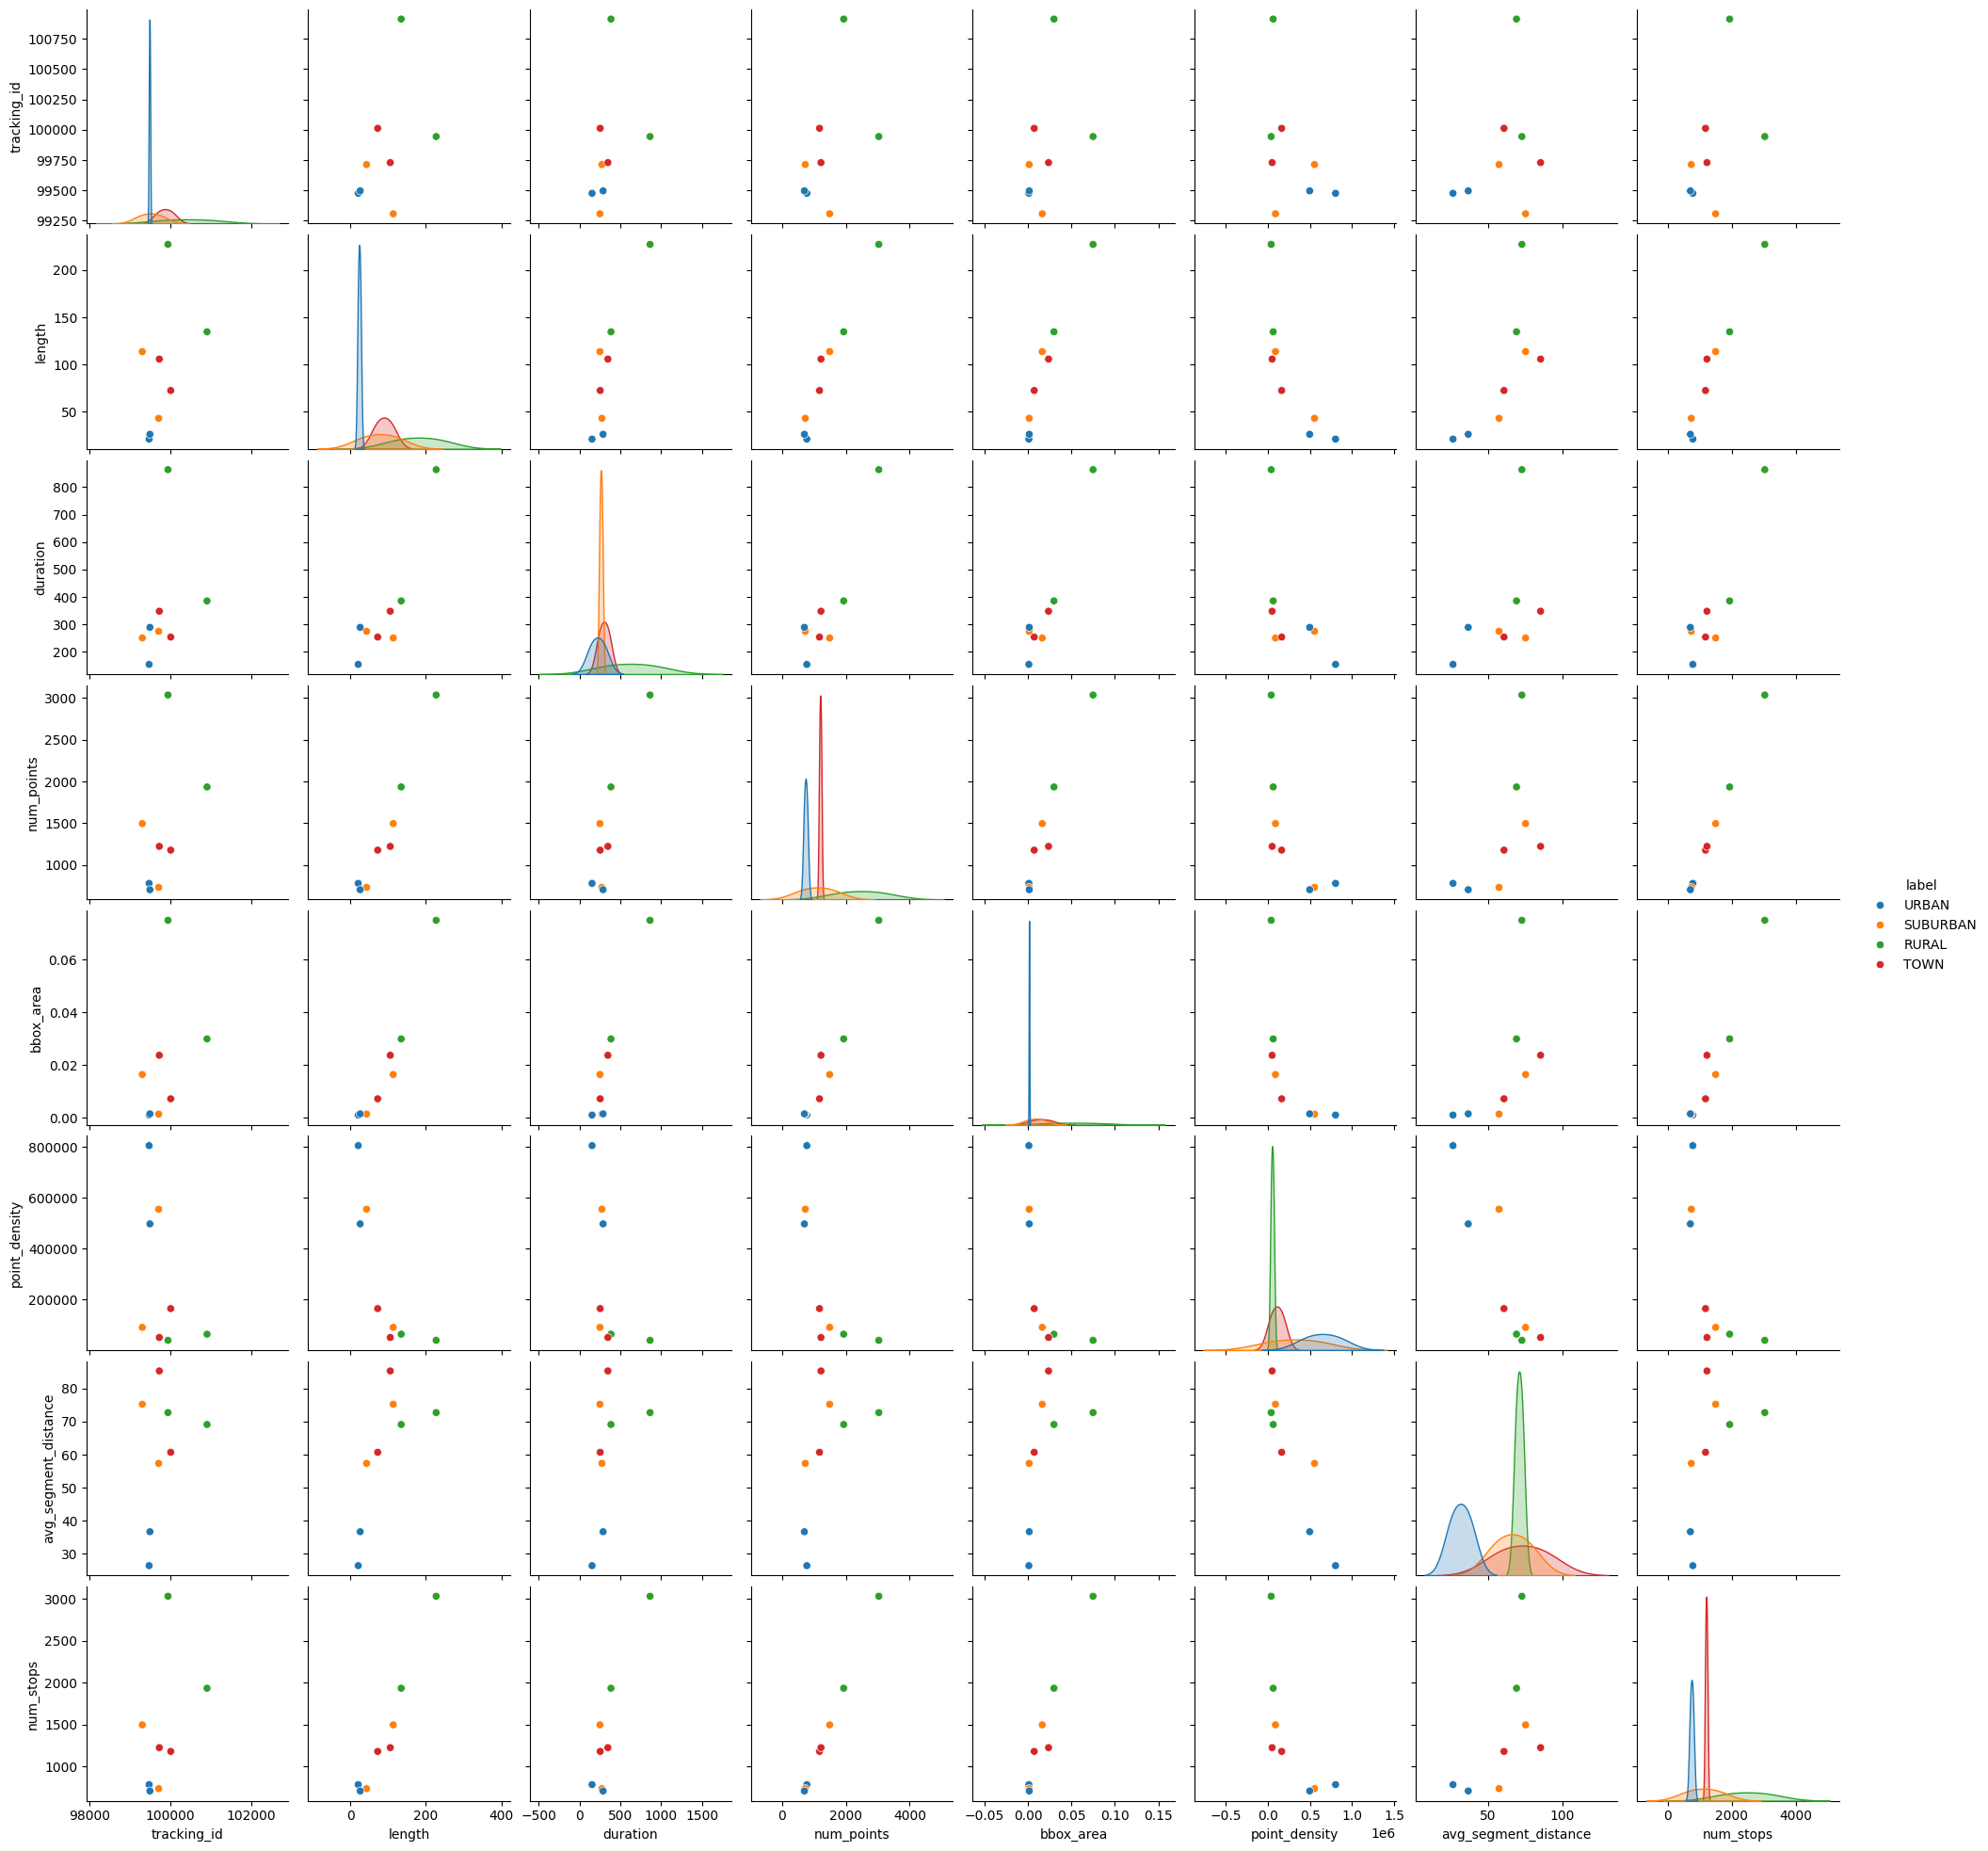

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(features_df, hue="label")
plt.show()


Text(0.5, 1.0, 'Point Density by Area Type')

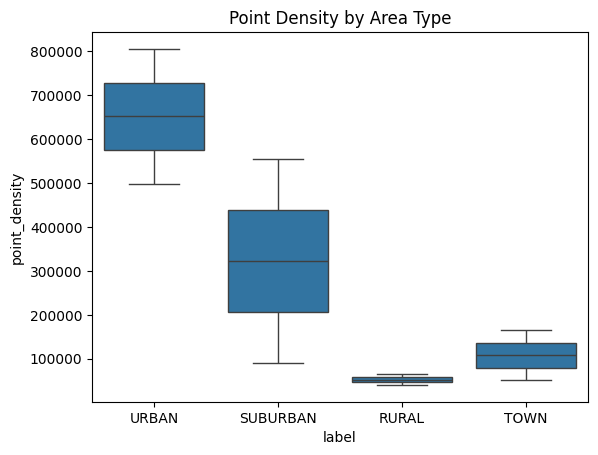

In [7]:
sns.boxplot(data=features_df, x="label", y="point_density")
plt.title("Point Density by Area Type")
